Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 26-June-2025

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/Connectomics/'
syn_prediction = 'princeton' # 'Princeton' for dataset from October 2024
syn_thresh = 5

In [3]:
# Load connectivity 
if syn_prediction == 'princeton':
    df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections_princeton.csv')
    df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
else:
    df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections.csv')
    
# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [4]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [5]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [6]:
# Get IDs
all_nodes = pd.unique(df_connectivity[['pre_root_id', 'post_root_id']].values.ravel('K')) 

In [7]:
# Build network graph
net = nx.DiGraph() 

# Add nodes
net.add_nodes_from(all_nodes)

In [8]:
# Add edges
for index, row in tqdm(df_connectivity.iterrows(), total=np.size(df_connectivity,axis=0)): 
    net.add_edge(df_connectivity["pre_root_id"][index], 
                 df_connectivity["post_root_id"][index], 
                 weight=int(df_connectivity.syn_count[index]))  

In [104]:
# Select source and target nodes
source_nodes = df_neurons_of_interest.root_id[df_neurons_of_interest.community_name.str.contains('BPN')].tolist()
#source_nodes = df_class.root_id[(df_class['class']=='mechanosensory')].unique().tolist()
target_nodes = df_neurons_of_interest.root_id[df_neurons_of_interest.community_name.str.contains('DNg12')].tolist()

# For every source node, find shortest path to every target node
hops = []
for source_node in source_nodes:
    hops_temp = []
    for target_node in target_nodes: 
        if source_node in net.nodes() and target_node in net.nodes():
            if nx.has_path(net, source_node, target_node):
                shortest_path = nx.shortest_path(net, source=source_node, target=target_node)
                hops_temp.append(len(shortest_path)-1)
    if len(hops_temp)>0:
        hops.append(np.min(hops_temp))

In [105]:
np.mean(hops)

np.float64(2.8125)

In [12]:
# Plot histogram
#plt.hist(hops)
#plt.xlim([0,10])
#plt.show()

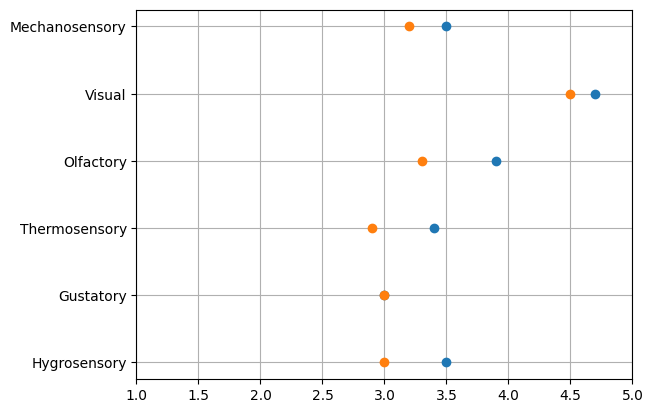

In [15]:
# Plot hops from target neurons
#target = ['aDN1', 'aDN2', 'aDN3', 'DNg11', 'DNg12']
#hops_RR = [3, 2.5, 2.5, 3.5, 2.5]
#hops_BPN = [2.9, 3, 3, 3.4, 2.8]

target = ['Mechanosensory', 'Visual', 'Olfactory', 'Thermosensory', 'Gustatory','Hygrosensory']
hops_RR = [3.5, 4.7, 3.9, 3.4, 3, 3.5]
hops_BPN = [3.2, 4.5, 3.3, 2.9, 3, 3]

fig, ax = plt.subplots()
plt.plot(hops_RR, range(len(target)),'o',)
plt.plot(hops_BPN, range(len(target)),'o',)
ax.set_yticks(range(len(target)))
ax.set_yticklabels(target)
plt.xlim([1,5])
plt.grid()
plt.gca().invert_yaxis()
#plt.savefig(r"C:\Users\Chris\Desktop\hops.eps", transparent=True)
plt.show()